In [1]:
from ultralytics import YOLO
from PIL import Image
import numpy as np
import cv2

/home/mees/.local/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (4.0.0)/charset_normalizer (3.0.1) doesn't match a supported version!
  warnings.warn(


In [9]:
model = YOLO("../models/last.pt")

In [14]:
img = 'IMG_2064.jpg'
results = model(img)
annotated_image = results[0].plot()

annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

annotated_image = Image.fromarray(annotated_image)
annotated_image.show()


image 1/1 /home/mees/Desktop/UVA/Scriptie/License-Plate-Recognition-Thesis/test_notebooks/IMG_2064.jpg: 640x480 1 0, 272.8ms
Speed: 6.6ms preprocess, 272.8ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 480)


In [168]:
from PIL import Image, ImageDraw, ImageFont
model = YOLO("../models/last.pt")
img = 'car1.jpg'
results = model(img)
annotated_image = results[0].plot()

annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

annotated_image = Image.fromarray(annotated_image)

# print(type(results))
# print(results)
polygon_points = results[0].masks.xy[0]
first_point = polygon_points[0]

draw = ImageDraw.Draw(annotated_image)
# draw circle at first point
draw.ellipse((first_point[0]-5, first_point[1]-5, first_point[0]+5, first_point[1]+5), fill='red')



annotated_image.show()


# print(polygon_points)



image 1/1 /home/mees/Desktop/UVA/Scriptie/License-Plate-Recognition-Thesis/test_notebooks/car1.jpg: 512x640 1 0, 333.0ms
Speed: 13.1ms preprocess, 333.0ms inference, 30.4ms postprocess per image at shape (1, 3, 512, 640)


In [11]:
model = YOLO("../models/obb-150ep.pt")


image 1/1 /home/mees/Desktop/UVA/Scriptie/License-Plate-Recognition-Thesis/test_notebooks/images/IMG_2065.jpg: 640x608 371.8ms
Speed: 7.3ms preprocess, 371.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 608)


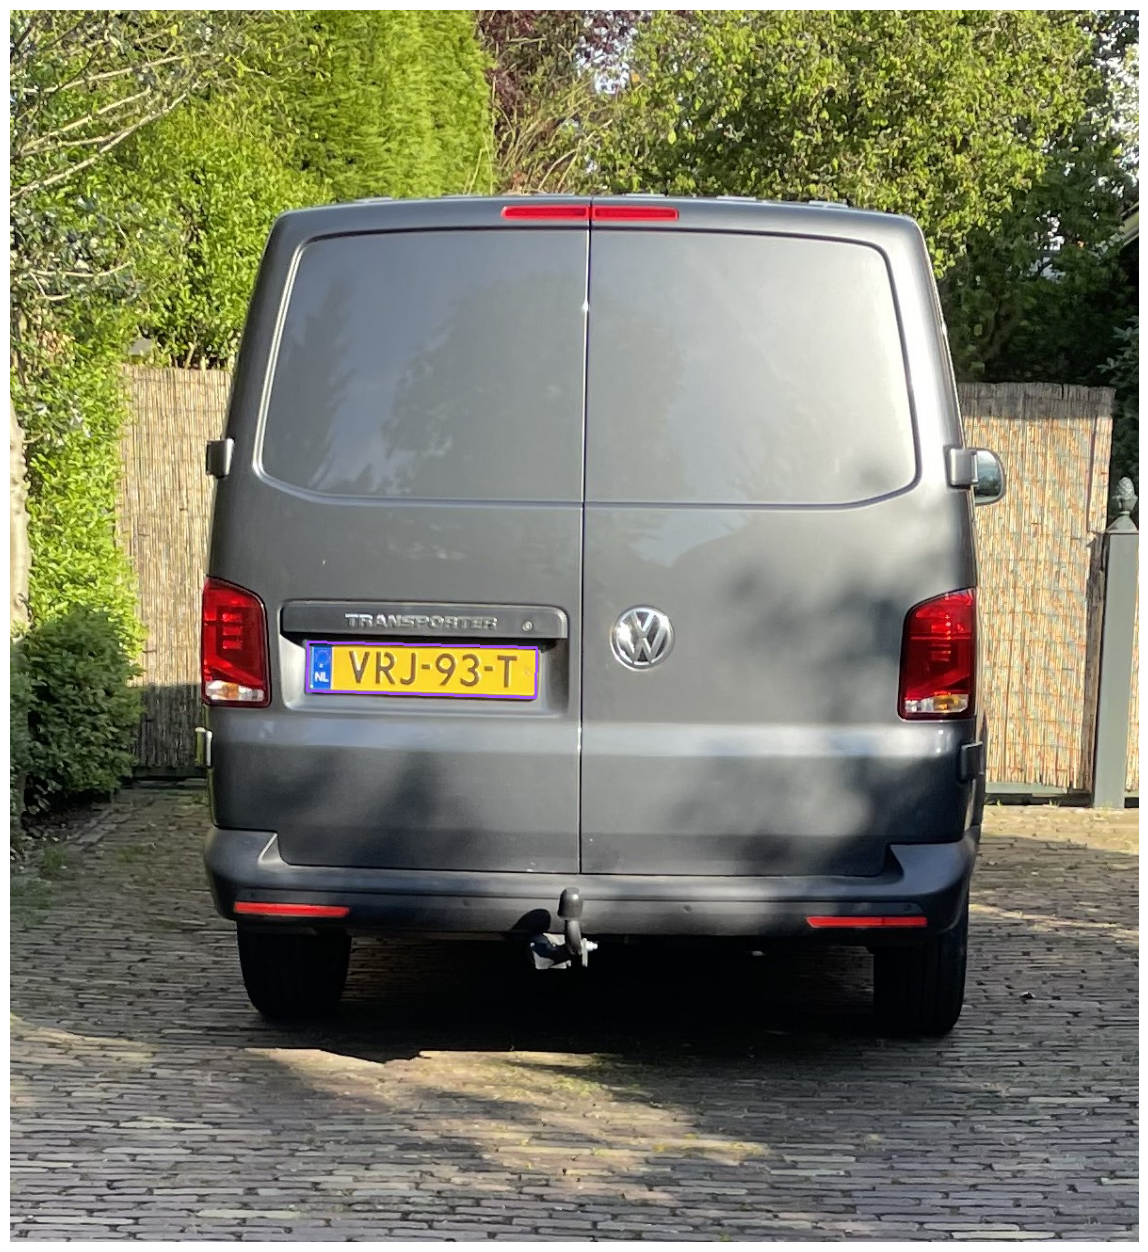

In [58]:
import supervision as sv

img = 'images/IMG_2065.jpg'
results = model(img)


detections = sv.Detections.from_ultralytics(results[0])


oriented_box_annotator = sv.OrientedBoxAnnotator()
annotated_frame = oriented_box_annotator.annotate(
    scene=cv2.imread(img),
    detections=detections
)

sv.plot_image(image=annotated_frame, size=(16, 16))


image 1/1 /home/mees/Desktop/UVA/Scriptie/License-Plate-Recognition-Thesis/test_notebooks/images/IMG_2065.jpg: 640x608 222.3ms
Speed: 6.7ms preprocess, 222.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 608)


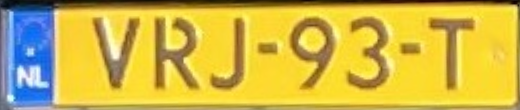

In [70]:
def crop_license_plate(img):
    results = model(img)


    detections = sv.Detections.from_ultralytics(results[0])
    xyxyxyxy = detections[0].data['xyxyxyxy'][0]

    point1, point2, point3, point4 = xyxyxyxy
    box_points = [point3, point2, point1, point4]

    # make blank image of size 520x110
    blank_image = np.zeros((110, 520, 3), np.uint8)
    blank_image[:] = (255, 255, 255)

    # warp
    matrix = cv2.getPerspectiveTransform(np.array(box_points, dtype=np.float32), np.array([[0, 0], [520, 0], [520, 110], [0, 110]], dtype=np.float32))
    warped = cv2.warpPerspective(cv2.imread(img), matrix, (520, 110))

    warped = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)
    warped = Image.fromarray(warped)
    # warped.show()
    return warped



crop_license_plate('images/IMG_2065.jpg')

In [95]:
import easyocr
reader = easyocr.Reader(['en'])

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [105]:
cropped = crop_license_plate('images/seat.webp')
# save cropped image
cropped.save('cropped.jpg')
cropped.show()
flipped = cropped.transpose(Image.FLIP_TOP_BOTTOM)
flipped = flipped.transpose(Image.FLIP_LEFT_RIGHT)
flipped.show()
flipped.save('flipped.jpg')
cropped = flipped

result = reader.readtext(np.array(cropped))
result


image 1/1 /home/mees/Desktop/UVA/Scriptie/License-Plate-Recognition-Thesis/test_notebooks/images/seat.webp: 384x640 198.0ms
Speed: 11.1ms preprocess, 198.0ms inference, 16.1ms postprocess per image at shape (1, 3, 384, 640)


[([[468, 22], [504, 22], [504, 52], [468, 52]], 'IN', 0.44483599099237836),
 ([[23, 2], [456, 2], [456, 104], [23, 104]], 'J8-681-$', 0.3693519490828554)]

In [109]:
import cv2
img = cv2.imread('cropped.jpg', cv2.IMREAD_GRAYSCALE)
kernel = np.ones((5,5),np.uint8)
opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
cv2.imwrite('opening.jpg', opening)

True